Fetching PJM load data for MIDATL from 2024-03-22 to 2025-03-21...
Generated synthetic PJM data and saved to data\pjm_MIDATL_2024-03-22_2025-03-21.csv
Fetching weather data for KPHL from 2024-03-22 to 2025-03-21...
Generated synthetic weather data and saved to data\weather_KPHL_2024-03-22_2025-03-21.csv
Prepared dataset with 8569 rows and 20 columns
Training model...
Model Evaluation Metrics:
MAE: 987.22 MW
RMSE: 1230.15 MW
MAPE: 4.88%
Evaluation plot saved to data\forecast_evaluation.png

Feature Importance:
             feature  importance
11     load_lag_168h    0.807541
8        load_lag_1h    0.144147
9       load_lag_24h    0.029350
3               hour    0.003999
4        day_of_week    0.003329
0        temperature    0.003231
6        day_of_year    0.002946
12  load_rolling_24h    0.002359
10      load_lag_48h    0.001442
2        cloud_cover    0.000612
Forecasting demand for the next 2 days...
Forecast plot saved to data\load_forecast.png
             datetime       load_m

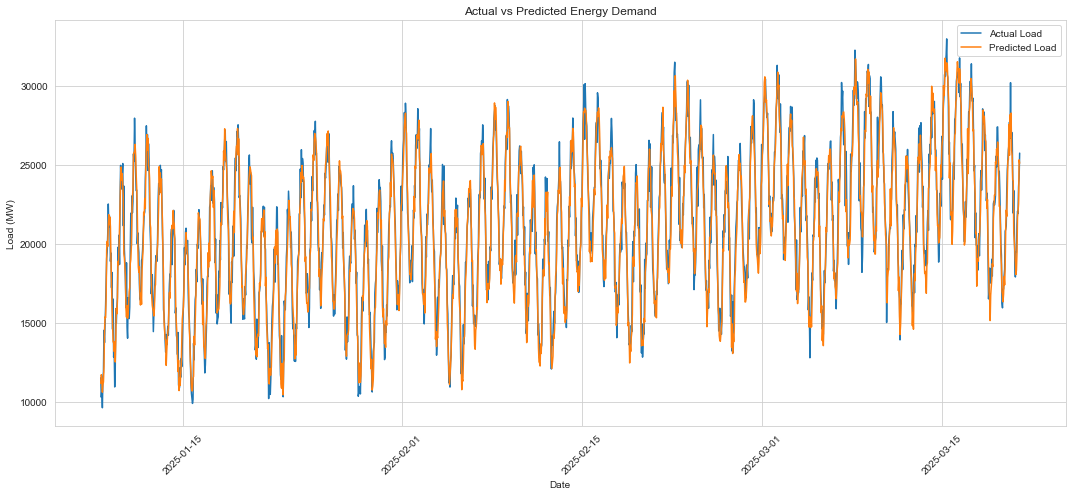

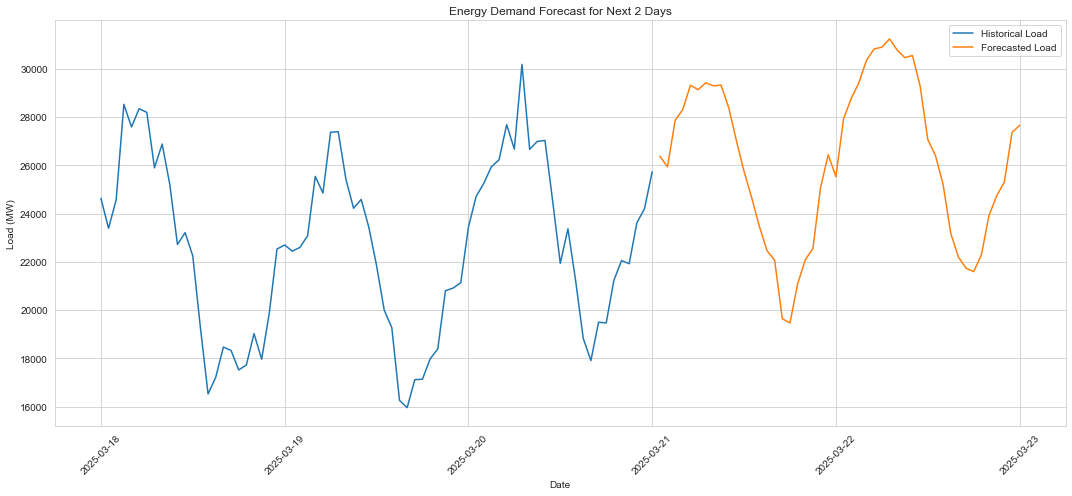

In [1]:
# Energy Demand Forecasting System
# Author: Richard Kagame
# Date: March 22, 2025

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import requests
import json
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import holidays
import warnings
warnings.filterwarnings('ignore')

# Setting style for plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

class EnergyDemandForecaster:
    """
    A class to forecast energy demand using historical electricity consumption
    and weather data.
    """
    
    def __init__(self, data_dir="data"):
        """
        Initializing the forecaster with data directory paths.
        
        Parameters:
        -----------
        data_dir : str
            Directory to store and retrieve data files
        """
        self.data_dir = data_dir
        self.load_data = None
        self.weather_data = None
        self.merged_data = None
        self.model = None
        self.scaler = StandardScaler()
        self.us_holidays = holidays.US()
        
        # Create data directory if it doesn't exist
        if not os.path.exists(data_dir):
            os.makedirs(data_dir)
    
    def fetch_pjm_data(self, start_date, end_date, region="MIDATL"):
        """
        Fetching electricity load data from PJM Interconnection.
        
        Parameters:
        -----------
        start_date : str
            Start date in format 'YYYY-MM-DD'
        end_date : str
            End date in format 'YYYY-MM-DD'
        region : str
            PJM region code
            
        Returns:
        --------
        DataFrame with hourly electricity load data
        """
        print(f"Fetching PJM load data for {region} from {start_date} to {end_date}...")

        cache_file = os.path.join(self.data_dir, f"pjm_{region}_{start_date}_{end_date}.csv")
        
        if os.path.exists(cache_file):
            print(f"Loading cached PJM data from {cache_file}")
            return pd.read_csv(cache_file, parse_dates=['datetime'])
        
        # Generating synthetic data    
        date_range = pd.date_range(start=start_date, end=end_date, freq='H')
        
        # Creating synthetic load data 
        base_load = 20000  # Base load in MW
        daily_pattern = np.sin(np.linspace(0, 2*np.pi, 24)) * 5000 + 5000  # Daily cycle
        weekly_pattern = np.sin(np.linspace(0, 2*np.pi, 7*24)) * 3000  # Weekly cycle
        seasonal_pattern = np.sin(np.linspace(0, 2*np.pi, 365*24)) * 7000  # Yearly cycle
        
        # Generating load data
        load_values = []
        for i, dt in enumerate(date_range):
            hour_of_day = dt.hour
            day_of_week = dt.dayofweek
            day_of_year = dt.dayofyear
            
            # Computing load with patterns
            load = (base_load + 
                   daily_pattern[hour_of_day] + 
                   weekly_pattern[i % len(weekly_pattern)] + 
                   seasonal_pattern[i % len(seasonal_pattern)])
            
            # Adding noise
            load += np.random.normal(0, 1000)
            
            load_values.append(max(0, load))  # Ensure non-negative
        
        # Creating dataframe
        data = pd.DataFrame({
            'datetime': date_range,
            'load_mw': load_values,
            'region': region
        })
        
        # Saving to cache
        data.to_csv(cache_file, index=False)
        print(f"Generated synthetic PJM data and saved to {cache_file}")
        
        return data
    
    def fetch_weather_data(self, start_date, end_date, location="KPHL"):
        """
        Fetching historical weather data from NOAA or weather API.
        
        Parameters:
        -----------
        start_date : str
            Start date in format 'YYYY-MM-DD'
        end_date : str
            End date in format 'YYYY-MM-DD'
        location : str
            Weather station code or location
            
        Returns:
        --------
        DataFrame with hourly weather data
        """
        print(f"Fetching weather data for {location} from {start_date} to {end_date}...")
        
        # Checking if we have cached data
        cache_file = os.path.join(self.data_dir, f"weather_{location}_{start_date}_{end_date}.csv")
        
        if os.path.exists(cache_file):
            print(f"Loading cached weather data from {cache_file}")
            return pd.read_csv(cache_file, parse_dates=['datetime'])
        

        
        date_range = pd.date_range(start=start_date, end=end_date, freq='H')
        
        # Creating synthetic weather data with seasonal patterns
        seasonal_temp = np.sin(np.linspace(0, 2*np.pi, 365*24)) * 15 + 15  # Yearly temperature cycle
        daily_temp = np.sin(np.linspace(0, 2*np.pi, 24)) * 5  # Daily temperature cycle
        
        # Generating weather data
        data = []
        for i, dt in enumerate(date_range):
            hour_of_day = dt.hour
            day_of_year = dt.dayofyear
            
            # Computing temperature with patterns
            temp = (seasonal_temp[i % len(seasonal_temp)] + 
                   daily_temp[hour_of_day] + 
                   np.random.normal(0, 3))  # Add noise
            
            # Computing humidity (inverse relationship with temperature)
            humidity = max(min(100 - temp + np.random.normal(50, 10), 100), 0)
            
            # Computing cloud cover
            cloud_cover = min(max(np.random.normal(50, 30), 0), 100)
            
            data.append({
                'datetime': dt,
                'temperature': temp,
                'humidity': humidity,
                'cloud_cover': cloud_cover,
                'station': location
            })
        
        # Creating dataframe
        weather_df = pd.DataFrame(data)
        
        # Saving to cache
        weather_df.to_csv(cache_file, index=False)
        print(f"Generated synthetic weather data and saved to {cache_file}")
        
        return weather_df
    
    def prepare_data(self, start_date, end_date, pjm_region="MIDATL", weather_station="KPHL"):
        """
        Preparing and merging electricity load and weather data.
        
        Parameters:
        -----------
        start_date : str
            Start date in format 'YYYY-MM-DD'
        end_date : str
            End date in format 'YYYY-MM-DD'
        pjm_region : str
            PJM region code
        weather_station : str
            Weather station code
            
        Returns:
        --------
        DataFrame with merged load and weather data
        """
        # Fetching load and weather data
        self.load_data = self.fetch_pjm_data(start_date, end_date, region=pjm_region)
        self.weather_data = self.fetch_weather_data(start_date, end_date, location=weather_station)
        
        # Merging data on datetime
        merged_data = pd.merge(self.load_data, self.weather_data, on='datetime')
        
        # Extracting time features
        merged_data['hour'] = merged_data['datetime'].dt.hour
        merged_data['day_of_week'] = merged_data['datetime'].dt.dayofweek
        merged_data['month'] = merged_data['datetime'].dt.month
        merged_data['year'] = merged_data['datetime'].dt.year
        merged_data['day_of_year'] = merged_data['datetime'].dt.dayofyear
        
        # Adding holiday feature
        merged_data['is_holiday'] = merged_data['datetime'].dt.date.apply(
            lambda x: 1 if x in self.us_holidays else 0
        )
        
        # Adding lagged features
        for lag in [1, 24, 48, 168]:  # 1 hour, 1 day, 2 days, 1 week
            merged_data[f'load_lag_{lag}h'] = merged_data['load_mw'].shift(lag)
        
        # Adding rolling mean features
        for window in [24, 48, 168]:  # 1 day, 2 days, 1 week
            merged_data[f'load_rolling_{window}h'] = merged_data['load_mw'].rolling(window=window).mean()
        
        # Dropping rows with NaN values (from lagging/rolling)
        merged_data = merged_data.dropna()
        
        self.merged_data = merged_data
        return merged_data
    
    def train_model(self, test_size=0.2, random_state=42):
        """
        Training a machine learning model on the prepared data.
        
        Parameters:
        -----------
        test_size : float
            Proportion of data to use for testing
        random_state : int
            Random seed for reproducibility
            
        Returns:
        --------
        Trained model and evaluation metrics
        """
        if self.merged_data is None:
            raise ValueError("Data not prepared. Call prepare_data() first.")
        
        print("Training model...")
        
        # Defining features and target
        features = [
            'temperature', 'humidity', 'cloud_cover', 
            'hour', 'day_of_week', 'month', 'day_of_year', 'is_holiday',
            'load_lag_1h', 'load_lag_24h', 'load_lag_48h', 'load_lag_168h',
            'load_rolling_24h', 'load_rolling_48h', 'load_rolling_168h'
        ]
        
        X = self.merged_data[features]
        y = self.merged_data['load_mw']
        
       
        train_size = int(len(X) * (1 - test_size))
        X_train, X_test = X[:train_size], X[train_size:]
        y_train, y_test = y[:train_size], y[train_size:]
        
       
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        
        # Training model
        model = GradientBoostingRegressor(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=5,
            random_state=random_state
        )
        
        model.fit(X_train_scaled, y_train)
        self.model = model
        
        # predictions
        y_pred = model.predict(X_test_scaled)
        
        # metrics
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mape = mean_absolute_percentage_error(y_test, y_pred) * 100
        
        print(f"Model Evaluation Metrics:")
        print(f"MAE: {mae:.2f} MW")
        print(f"RMSE: {rmse:.2f} MW")
        print(f"MAPE: {mape:.2f}%")
        
        # Plotting actual vs predicted
        test_dates = self.merged_data['datetime'][train_size:].reset_index(drop=True)
        
        plt.figure(figsize=(15, 7))
        plt.plot(test_dates, y_test.values, label='Actual Load')
        plt.plot(test_dates, y_pred, label='Predicted Load')
        plt.title('Actual vs Predicted Energy Demand')
        plt.xlabel('Date')
        plt.ylabel('Load (MW)')
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        
        # Save the plot
        plot_file = os.path.join(self.data_dir, 'forecast_evaluation.png')
        plt.savefig(plot_file)
        print(f"Evaluation plot saved to {plot_file}")
        
        # Feature importance
        feature_importance = pd.DataFrame({
            'feature': features,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        print("\nFeature Importance:")
        print(feature_importance.head(10))
        
        return {
            'model': model,
            'metrics': {
                'mae': mae,
                'rmse': rmse,
                'mape': mape
            },
            'feature_importance': feature_importance
        }
    
    def forecast_next_days(self, days=2):
        """
        Forecasting energy demand for the next specified number of days.
        
        Parameters:
        -----------
        days : int
            Number of days to forecast
            
        Returns:
        --------
        DataFrame with forecasted load values
        """
        if self.model is None:
            raise ValueError("Model not trained. Call train_model() first.")
        
        print(f"Forecasting demand for the next {days} days...")
        
        # Geting the last date in the data
        last_date = self.merged_data['datetime'].max()
        
        # Creating date range for the forecast period
        forecast_dates = pd.date_range(
            start=last_date + timedelta(hours=1),
            periods=days*24,
            freq='H'
        )
        
        # Creating a DataFrame for the forecast
        forecast_df = pd.DataFrame({'datetime': forecast_dates})
        
        # Extracting time features
        forecast_df['hour'] = forecast_df['datetime'].dt.hour
        forecast_df['day_of_week'] = forecast_df['datetime'].dt.dayofweek
        forecast_df['month'] = forecast_df['datetime'].dt.month
        forecast_df['day_of_year'] = forecast_df['datetime'].dt.dayofyear
        forecast_df['is_holiday'] = forecast_df['datetime'].dt.date.apply(
            lambda x: 1 if x in self.us_holidays else 0
        )
        
        # Adding weather forecast data
        # Using simple seasonal patterns based on the last observed values
        last_temp = self.merged_data['temperature'].iloc[-1]
        last_humidity = self.merged_data['humidity'].iloc[-1]
        last_cloud = self.merged_data['cloud_cover'].iloc[-1]
        
        forecast_df['temperature'] = [
            last_temp + np.sin(i/24 * np.pi) * 5 + np.random.normal(0, 1)
            for i in range(len(forecast_df))
        ]
        
        forecast_df['humidity'] = [
            max(min(last_humidity - 0.5 * (temp - last_temp) + np.random.normal(0, 5), 100), 0)
            for temp in forecast_df['temperature']
        ]
        
        forecast_df['cloud_cover'] = [
            max(min(last_cloud + np.random.normal(0, 10), 100), 0)
            for _ in range(len(forecast_df))
        ]
        
        # Initializing load lag columns with the last known values
        last_loads = {}
        for lag in [1, 24, 48, 168]:
            col_name = f'load_lag_{lag}h'
            last_loads[lag] = list(self.merged_data['load_mw'].iloc[-lag:])
        
        last_rolling = {}
        for window in [24, 48, 168]:
            col_name = f'load_rolling_{window}h'
            last_rolling[window] = self.merged_data[col_name].iloc[-1]
        
        # Iterating through each hour in the forecast period
        forecast_loads = []
        
        for i in range(len(forecast_df)):
            # Updating lag features
            current_features = forecast_df.iloc[i].copy()
            
            for lag in [1, 24, 48, 168]:
                col_name = f'load_lag_{lag}h'
                if i < lag:
                    # Using historical data
                    current_features[col_name] = last_loads[lag][-(lag-i)]
                else:
                    # Using previously forecasted values
                    current_features[col_name] = forecast_loads[i-lag]
            
            # Updating rolling mean features
            for window in [24, 48, 168]:
                col_name = f'load_rolling_{window}h'
                if i == 0:
                    current_features[col_name] = last_rolling[window]
                else:
                    # Simple approximation of rolling mean
                    prev_rolling = forecast_df.iloc[i-1][col_name] if i >= 1 else last_rolling[window]
                    prev_load = forecast_loads[i-1]
                    current_features[col_name] = prev_rolling * (window-1)/window + prev_load/window
            
            # Extracting features for prediction
            features = [
                'temperature', 'humidity', 'cloud_cover', 
                'hour', 'day_of_week', 'month', 'day_of_year', 'is_holiday',
                'load_lag_1h', 'load_lag_24h', 'load_lag_48h', 'load_lag_168h',
                'load_rolling_24h', 'load_rolling_48h', 'load_rolling_168h'
            ]
            
            X = pd.DataFrame([current_features[features]])
            
            
            X_scaled = self.scaler.transform(X)
            
            #prediction
            load_pred = self.model.predict(X_scaled)[0]
            forecast_loads.append(load_pred)
            
            # Updating the DataFrame
            forecast_df.at[i, 'load_mw'] = load_pred
            
            # Updating rolling means for next iteration
            for window in [24, 48, 168]:
                col_name = f'load_rolling_{window}h'
                forecast_df.at[i, col_name] = current_features[col_name]
        
        # Plotting the forecast
        plt.figure(figsize=(15, 7))
        
        # Plotting the last 3 days of historical data
        hist_end = self.merged_data['datetime'].max()
        hist_start = hist_end - timedelta(days=3)
        hist_data = self.merged_data[(self.merged_data['datetime'] >= hist_start) & 
                                     (self.merged_data['datetime'] <= hist_end)]
        
        plt.plot(hist_data['datetime'], hist_data['load_mw'], label='Historical Load')
        plt.plot(forecast_df['datetime'], forecast_df['load_mw'], label='Forecasted Load')
        
        plt.title(f'Energy Demand Forecast for Next {days} Days')
        plt.xlabel('Date')
        plt.ylabel('Load (MW)')
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        
        # Saving the plot
        plot_file = os.path.join(self.data_dir, 'load_forecast.png')
        plt.savefig(plot_file)
        print(f"Forecast plot saved to {plot_file}")
        
        return forecast_df[['datetime', 'load_mw']]
    
    def save_model(self, filename="energy_forecast_model.pkl"):
        """Save the trained model to a file."""
        import pickle
        if self.model is None:
            raise ValueError("No trained model to save.")
        
        model_path = os.path.join(self.data_dir, filename)
        with open(model_path, 'wb') as f:
            pickle.dump({
                'model': self.model,
                'scaler': self.scaler
            }, f)
        
        print(f"Model saved to {model_path}")
    
    def load_model(self, filename="energy_forecast_model.pkl"):
        """Load a trained model from a file."""
        import pickle
        model_path = os.path.join(self.data_dir, filename)
        
        if not os.path.exists(model_path):
            raise FileNotFoundError(f"Model file {model_path} not found.")
        
        with open(model_path, 'rb') as f:
            saved_data = pickle.load(f)
            self.model = saved_data['model']
            self.scaler = saved_data['scaler']
        
        print(f"Model loaded from {model_path}")


if __name__ == "__main__":

    forecaster = EnergyDemandForecaster()
    end_date = '2025-03-21'  # Yesterday
    start_date = '2024-03-22'  # One year ago
    
    data = forecaster.prepare_data(start_date, end_date)
    print(f"Prepared dataset with {len(data)} rows and {data.shape[1]} columns")

    results = forecaster.train_model(test_size=0.2)
    
    # Making forecast for next 48 hours
    forecast = forecaster.forecast_next_days(days=2)
    print(forecast.head())
    
    # Saveing the model
    forecaster.save_model()
    
    print("Energy demand forecasting completed successfully.")